### **Project: expressEats**

***Part-2: In this Notebook we did continue training along with metrics***


***Note: We have other continued colabs, this is just part 3***

Look at our codebase below for more details

# > **Data Loading, Cleaning, Tokenisation**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import numpy as np

# Step 1: Load the Dataset
file_path = '/kaggle/input/6000-indian-food-recipes-dataset/IndianFoodDatasetCSV.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess Data - Remove rows with missing 'TranslatedIngredients'
data_cleaned = data.dropna(subset=['TranslatedIngredients'])

# Step 3: Feature Preparation
# Vectorize 'TranslatedIngredients'
vectorizer = TfidfVectorizer(stop_words='english')
X_ingredients = vectorizer.fit_transform(data_cleaned['TranslatedIngredients'])

# Standardize 'TotalTimeInMins'
scaler = StandardScaler()
X_time = scaler.fit_transform(data_cleaned[['TotalTimeInMins']])

# Combine the features
X_combined = sp.hstack((X_ingredients, X_time), format='csr')

# > **KMeans Training**

In [ ]:
# Step 4: Train KMeans Model
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_combined)
data_cleaned['Cluster'] = kmeans.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_19/3370755713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Cluster'] = kmeans.labels_


# > **KMeans Inference**

In [ ]:


# Step 5: Select an Example
example_row = data_cleaned.sample(random_state=42)
print(example_row.iloc[0])
example_translated_ingredients = example_row['TranslatedIngredients'].iloc[0]
example_total_time = example_row['TotalTimeInMins'].iloc[0]

# Vectorize and standardize the example
example_ingredients_vectorized = vectorizer.transform([example_translated_ingredients])
example_time_standardized = scaler.transform([[example_total_time]])
example_combined = sp.hstack((example_ingredients_vectorized, example_time_standardized), format='csr')

# Step 6: Find Nearest Recipe
# Predict cluster for the example
example_cluster = kmeans.predict(example_combined)[0]

# Data points from the same cluster
cluster_data = data_cleaned[data_cleaned['Cluster'] == example_cluster]

# Mapping index for distance calculation
index_mapping = {index: i for i, index in enumerate(data_cleaned.index)}

# Function to calculate Euclidean distance for sparse matrices
def euclidean_distance_sparse(row_index, dense_row):
    sparse_row = X_combined[index_mapping[row_index]]
    return np.linalg.norm(sparse_row.toarray() - dense_row)

# Calculating distances within the cluster
cluster_data['Distance'] = cluster_data.index.map(
    lambda index: euclidean_distance_sparse(index, example_combined.toarray()))

# Identifying nearest recipe
nearest_recipe_index = cluster_data['Distance'].idxmin()
nearest_recipe = cluster_data.loc[nearest_recipe_index]

nearest_recipe[['TranslatedRecipeName', 'Distance']]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Srno                                                                   1751
RecipeName                Pudina Mavinakayi Chutney Recipe - Mint Mango ...
TranslatedRecipeName      Pudina Mavinakayi Chutney Recipe - Mint Mango ...
Ingredients               1 Mango (Raw) - grated,1 cup Fresh coconut,1/2...
TranslatedIngredients     1 Mango (Raw) - grated,1 cup Fresh coconut,1/2...
PrepTimeInMins                                                           15
CookTimeInMins                                                            0
TotalTimeInMins                                                          15
Servings                                                                  4
Cuisine                                                           Karnataka
Course                                                            Side Dish
Diet                                                             Vegetarian
Instructions              To begin making the Karnataka Style Pudina Mav...
TranslatedIn

/tmp/ipykernel_19/2735290301.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Distance'] = cluster_data.index.map(


TranslatedRecipeName    Pudina Mavinakayi Chutney Recipe - Mint Mango ...
Distance                                                              0.0
Name: 1552, dtype: object

# > **KMeans Cluster Visualization and cluster metrics**

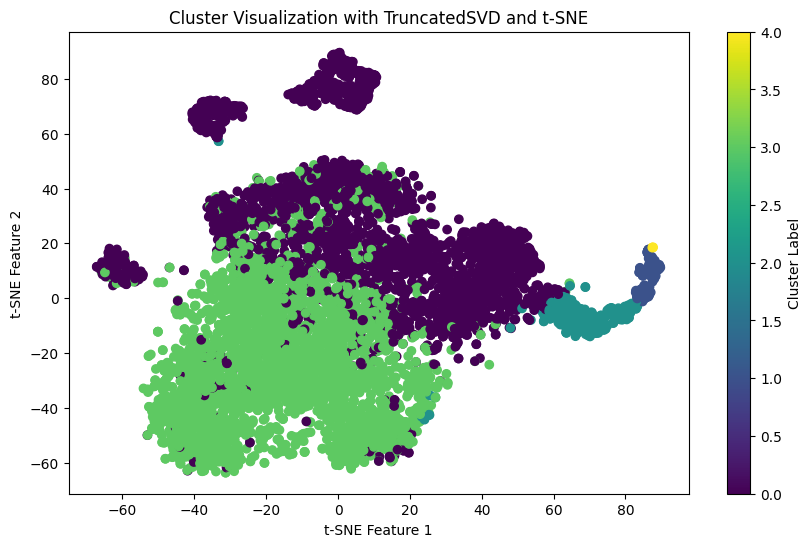

(0.09787780826754199, 3307.8025971898037, 1.727193328699558)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score

import matplotlib.pyplot as plt

# Using TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_combined)

# Applying t-SNE on SVD-reduced data
tsne_svd = TSNE(n_components=2, random_state=42)
X_tsne_svd = tsne_svd.fit_transform(X_svd)

# Plotting the clusters after SVD and t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne_svd[:, 0], X_tsne_svd[:, 1], c=data_cleaned['Cluster'], cmap='viridis', marker='o')
plt.title('Cluster Visualization with TruncatedSVD and t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Recalculating the metrics using SVD-reduced data
silhouette_svd = silhouette_score(X_svd, data_cleaned['Cluster'])
calinski_harabasz_svd = calinski_harabasz_score(X_svd, data_cleaned['Cluster'])
davies_bouldin_svd = davies_bouldin_score(X_svd, data_cleaned['Cluster'])

silhouette_svd, calinski_harabasz_svd, davies_bouldin_svd


# > **All Possible Task Metrics**

In [ ]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Assigning the actual labels (TranslatedRecipeName) for the evaluation
labels_true = data_cleaned['TranslatedRecipeName']
labels_pred = data_cleaned['Cluster']

# 1. Homogeneity
homogeneity = homogeneity_score(labels_true, labels_pred)

# 2. Completeness
completeness = completeness_score(labels_true, labels_pred)

# 3. V-Measure
v_measure = v_measure_score(labels_true, labels_pred)

# 4. Adjusted Rand Index (ARI)
ari = adjusted_rand_score(labels_true, labels_pred)

# 5. Adjusted Mutual Information (AMI)
ami = adjusted_mutual_info_score(labels_true, labels_pred)

homogeneity, completeness, v_measure, ari, ami


(0.10450198304965984,
 0.9978160525203789,
 0.18918996667461824,
 9.734318895179761e-07,
 0.00025874879933965853)